# Imports

In [1]:
import osmnx as ox
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
import pandas as pd
from queue import PriorityQueue
from math import inf


import osmnx as ox
ox.settings.log_console=True
ox.settings.use_cache=True

# Speed-Up-Techniken


## Example Setup

In [5]:
adress = "Weingartener Straße 2, Stutensee, Deutschland"
base_graph = ox.graph_from_address(adress, dist=20000, dist_type='bbox', network_type='drive') # 10000, 20000, 50000

In [6]:
orig_cords = ox.geocode("Weingartener Straße 2, Stutensee, Deutschland")
orig_node = ox.nearest_nodes(base_graph, orig_cords[1], orig_cords[0])

dest_cords = ox.geocode("Moltkestraße 30, Karlsruhe, Deutschland")
dest_node = ox.nearest_nodes(base_graph, dest_cords[1], dest_cords[0]) 

## Bidirectional Search
- Beschreibung:
    - Pseudcode
    - Eigenschaften (Heuristik?, Speed-Up)
    - Vergleich Suchradien (zu normalen Dijkstra) 
- Einfache Implementierung:
    - Gedanke: Dijkstra 2x
    - OSMNX liefert DiGraphen. Hier muss bei Suche ausgehend von Ziel darauf geachtet werden, dass Predecessors (anstellen von Successors verwendet werden.)

In [7]:
def bidirectional_backtrace(pred_node_source, pred_node_target, start, intersection , end):
    
    # From intersection to start
    node = intersection
    path = []
    while node != start:
        path.append(node)
        node = pred_node_source[node]
    path.append(node) 
    path.reverse()

    # From intersection to end
    node = intersection
    while node != end:
        if node != intersection:
            path.append(node)
        node = pred_node_target[node]
    path.append(node)

    return path

In [11]:
# Bidirectional Dijkstra 
def bidirectional_dijkstra(graph, start, end):

    ## Initialisierung
    # Vorherige Node mit bisher kürzestem Weg zu aktueller Node 
    pred_node_source = {}
    pred_node_target = {}
    # Distanzen initialisieren für alle Nodes inf (unendlich) setzen, außer für unsere Start-Node hier wird 0 gesetzt
    dist_source = {v: inf for v in list(nx.nodes(graph))} 
    dist_source[start] = 0
    dist_target = {v: inf for v in list(nx.nodes(graph))} 
    dist_target[end] = 0
    
    # Bereits besuchte Nodes als Set
    visited_source = set()
    visited_target = set() 
    
    # prioritize nodes from start -> node with the shortest distance!
    ## elements stored as tuples (distance, node) 
    priority_queue_source = PriorityQueue()  
    priority_queue_source.put((dist_source[start], start))

    priority_queue_target = PriorityQueue()  
    priority_queue_target.put((dist_target[end], end))
    
    # Solange
    while len(visited_source.intersection(visited_target)) == 0:
        
        current_node_source_cost, current_source_node = priority_queue_source.get()
        current_node_target_cost, current_target_node = priority_queue_target.get()
        
        # Aktuell besuchte Node zu den besuchten hinzufügen
        visited_source.add(current_source_node)
        visited_target.add(current_target_node)

        # Source: Nachfolger der aktuellen Node abrufen und für jeden Nachfolger die Distanz berechnen
        for neighbor in dict(graph.adjacency()).get(current_source_node):
            path = dist_source[current_source_node] + graph.get_edge_data(current_source_node, neighbor).get('length')

            # Wenn die neue gefundene Distanz über den aktuellen Knoten kürzer ist als die bisher kürzeste Distanz
            if path < dist_source[neighbor]:
                # Die neue gefundene Distanz als kürzeste Distanz speichern
                dist_source[neighbor] = path
                # Die aktuelle Node als vorherige Node mit dem kürzesten Weg zur neuen Node setzen 
                pred_node_source[neighbor] = current_source_node
                # if we haven't visited the neighbor
                if neighbor not in visited_source:
                    # insert into priority queue
                    priority_queue_source.put((dist_source[neighbor], neighbor))
                # otherwise update the entry in the priority queue
                else:
                    # remove old
                    _ = priority_queue_source.get((dist_source[neighbor], neighbor))
                    # insert new
                    priority_queue_source.put((dist_source[neighbor], neighbor))


        # Target: Nachfolger der aktuellen Node abrufen und für jeden Nachfolger die Distanz berechnen
        for neighbor in graph.predecessors(current_target_node):
            path = dist_target[current_target_node] + graph.get_edge_data(neighbor, current_target_node).get('length')

            # Wenn die neue gefundene Distanz über den aktuellen Knoten kürzer ist als die bisher kürzeste Distanz
            if path < dist_target[neighbor]:
                # Die neue gefundene Distanz als kürzeste Distanz speichern
                dist_target[neighbor] = path
                # Die aktuelle Node als vorherige Node mit dem kürzesten Weg zur neuen Node setzen 
                pred_node_target[neighbor] = current_target_node
                # if we haven't visited the neighbor
                if neighbor not in visited_target:
                    # insert into priority queue 
                    priority_queue_target.put((dist_target[neighbor], neighbor))
                # otherwise update the entry in the priority queue
                else:
                    # remove old
                    _ = priority_queue_target.get((dist_target[neighbor], neighbor))
                    # insert new
                    priority_queue_target.put((dist_target[neighbor], neighbor))
    
    print(f"Visited Forward Search: {len(visited_source)}")
    print(f"Visited Backwards Search: {len(visited_target)}")
    intersection = visited_source.intersection(visited_target).pop()
    print(f"Intersection: {intersection}")
    print(f"Distance: {dist_target[intersection] + dist_source[intersection]}")
    return bidirectional_backtrace(pred_node_source, pred_node_target, start, intersection, end), dist_target[intersection] + dist_source[intersection]

In [12]:
di_graph = ox.utils_graph.get_digraph(base_graph, weight="length")

route_bi, dist = bidirectional_dijkstra(di_graph, orig_node, dest_node)

Visited Forward Search: 3595
Visited Backwards Search: 3557
Intersection: 21733389
Distance: 16187.009000000002


In [13]:
ox.plot_route_folium(base_graph, route_bi)

## Leveling
- Idee: Mit dem Multi-Level Ansatz können hierarchische Beziehungen in den Netzwerken genutzt werden, um den Suchraum für den kürzesten Weg zu reduzieren. So könnten z.B. in größerer Entfernung von Start und Ziel nur "wichtige" Straßen, wie z.B. Autobahnen oder Bundesstraßen betrachtet werden, da diese meist am schnellsten sind. In der Nähe von Start und Ziel müssen alle Straßen untersucht werden.
- Umsetzung: Nutzen der Einstufung von Straßen in Open-Street-Map, Je weiter weg, desto höher muss die Stufe sein, um in den Suchraum aufgenommen zu werden.
- Weitere Verfeinerungen für Heuristik: Algorithmus für Cliques, Algorithmen für Skeleton

In [41]:
adress = "Weingartener Straße 2, Stutensee, Deutschland"
detail_source_graph = ox.graph_from_address(adress, dist=5000, dist_type='bbox', network_type='drive') # 10000, 20000, 50000

In [42]:
adress = "Moltkestraße 30, Karlsruhe, Deutschland"
detail_target_graph = ox.graph_from_address(adress, dist=5000, dist_type='bbox', network_type='drive') # 10000, 20000, 50000

Sparse base graph with only important roads
- Explain OSM Classification

In [36]:
# Dict with Road-Classification
cf =  '["highway"~"motorway|trunk|primary|secondary|tertiary|motorway_link|trunk_link|primary_link|secondary_link|tertiary_link"]'

In [37]:
adress = "Weingartener Straße 2, Stutensee, Deutschland"
base_graph_sparse = ox.graph_from_address(adress, dist=20000, dist_type='bbox', network_type='drive', custom_filter=cf) # 10000, 20000, 50000

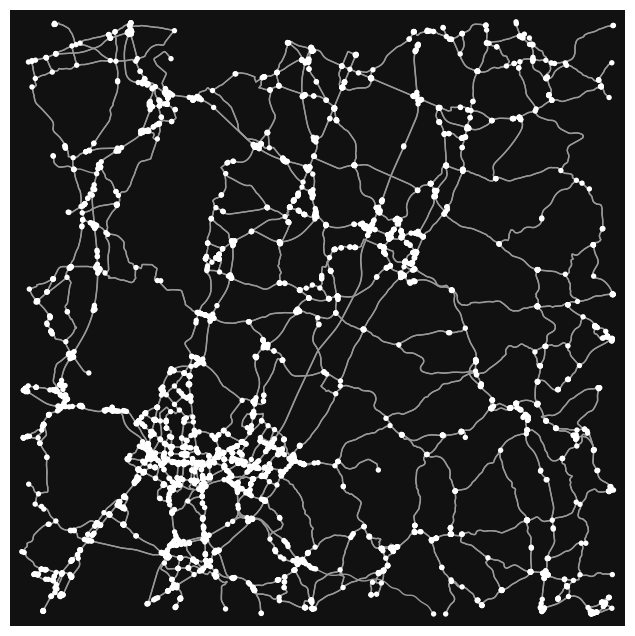

In [38]:
fig, ax = ox.plot_graph(base_graph_sparse)

In [39]:
print(len(base_graph.nodes()))
print(len(base_graph_sparse.nodes()))

28879
3864


In [53]:
base_nodes, base_edges = ox.graph_to_gdfs(base_graph_sparse, nodes=True, edges=True, node_geometry=True)
source_nodes, source_edges = ox.graph_to_gdfs(detail_source_graph, nodes=True, edges=True, node_geometry=True) #
target_nodes, target_edges = ox.graph_to_gdfs(detail_target_graph, nodes=True, edges=True, node_geometry=True) #

In [74]:
base_edges['osmid'].value_counts()

4679606                                                                      8
22912411                                                                     8
34965813                                                                     8
27432743                                                                     8
23769012                                                                     8
                                                                            ..
[117386461, 204804397, 204804383]                                            1
[366301602, 24719782, 385794023, 24719784, 24719785, 385794024, 84620369]    1
35008272                                                                     1
[366301602, 24719782, 385794023, 385794024, 24719785, 24719784, 84620369]    1
1126694675                                                                   1
Name: osmid, Length: 5638, dtype: int64

In [112]:
# Join all Geo Dataframes
leveling_edges = pd.concat([base_edges, source_edges, target_edges])
leveling_nodes = pd.concat([base_nodes, source_nodes, target_nodes])
# Remove duplicate nodes and edges
leveling_nodes = leveling_nodes[~leveling_nodes.index.duplicated(keep='first')]
leveling_edges = leveling_edges[~leveling_edges.index.duplicated(keep='first')]

In [106]:
leveling_graph = ox.graph_from_gdfs(leveling_nodes, leveling_edges, graph_attrs=None)

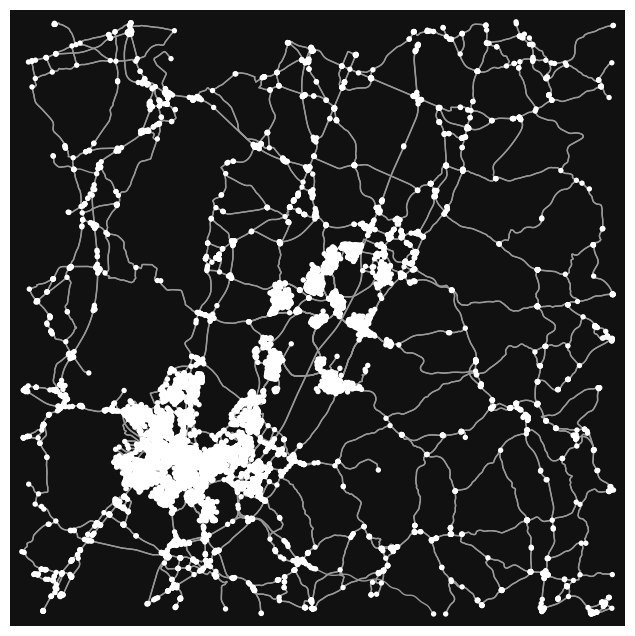

In [108]:
fig, ax = ox.plot_graph(leveling_graph)

In [109]:
print(f"Anzahl Knoten und Edges Base Graph: {len(base_graph.nodes())} nodes, {len(base_graph.edges())} edges")
print(f"Anzahl Knoten und Edges Sparse Base Graph: {len(leveling_graph.nodes())} nodes, {len(leveling_graph.edges())} edges")

Anzahl Knoten und Edges Base Graph: 28879 nodes, 70603 edges
Anzahl Knoten und Edges Sparse Base Graph: 8416 nodes, 19316 edges


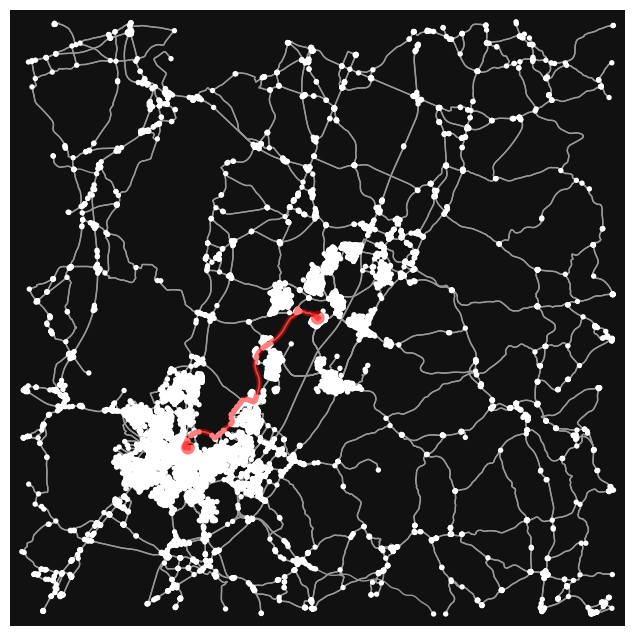

In [111]:
route = nx.dijkstra_path(G=leveling_graph, source=orig_node, target=dest_node, weight='length')
fig, ax = ox.plot_graph_route(leveling_graph, route, route_color='r')

## Ausblick